In [1]:
import sys
sys.path.append("..")

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataset import TCGADataset
from configs.templates import pancancer_autoenc
from configs.templates_cls import liver_types_mil
from mil.manipulate.manipulator_mil import ImageManipulator, compute_structural_similarity
from cmcrameri import cm
from PIL import Image
from huggingface_hub import hf_hub_download, login
from torchvision import transforms
import torch
import h5py

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("..")

In [2]:
patient_name = "TCGA-3X-AAVA-01Z-00-DX1"

In [ ]:
# for downloading pretrained MoPadi models authenticate with a Hugging Face API token
# you need to have obtained access to the MoPadi repository on Hugging Face: https://huggingface.co/KatherLab/MoPaDi
token = input("Enter your Hugging Face API token: ")
login(token=token)

# or set your Hugging Face token as an environment variable by running `export HF_TOKEN="your_token_here`
#token = os.getenv("HF_TOKEN")
#login(token=token)

In [3]:
# download model files
autoenc_model_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="pancancer_model/autoenc.ckpt",
)
print(f"Autoencoder's checkpoint downloaded to: {autoenc_model_path}")

clf_model_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="pancancer_model/mil_liver_classifier.pth",
)
print(f"Classifier's checkpoint downloaded to: {clf_model_path}")

autoenc.ckpt:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Autoencoder's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/ed49e7032171e0466a230665b3fce6baca6c62d6/pancancer_model/autoenc.ckpt


mil_liver_classifier.pth:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

Classifier's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/ed49e7032171e0466a230665b3fce6baca6c62d6/pancancer_model/mil_liver_classifier.pth


In [4]:
# looks for folders in 'images/example_data' containing patches
data = TCGADataset(
    images_dir=f"images/example_data",
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
)

In [5]:
# initialize image manipulator
manipulator = ImageManipulator(
    autoenc_config = pancancer_autoenc(),
    autoenc_path = autoenc_model_path, 
    mil_path = clf_model_path, 
    conf_cls = liver_types_mil(),
    dataset=data
)

Seed set to 0


Model params: 160.69 M
Both models loaded successfully.


In [6]:
# load previously extracted features for all tiles of the chosen patient
with h5py.File(f"images/example_data/{patient_name}/features.h5", "r") as hdf_file:
            if 'feats' in hdf_file:
                features = torch.from_numpy(hdf_file['feats'][:])
            elif 'features' in hdf_file:
                features = torch.from_numpy(hdf_file['features'][:])
            else:
                raise ValueError(f"Neither 'feats' nor 'features' found in {feat_path}")

            if 'metadata' in hdf_file:
                metadata = hdf_file["metadata"][:]
                metadata_decoded = [str(item, "utf-8") for item in metadata]

In [7]:
lvls = [0.02, 0.04, 0.06, 0.08, 0.1]

# 5 top predictive tiles of the chosen patient are being manipulated and saved to disk
manipulator.manipulate_patients_images(
    patient_name=patient_name, 
    patient_features=features.unsqueeze(dim=0),
    metadata=metadata_decoded,
    save_path="images/example_liver_cancer_types_mil", 
    man_amps=lvls,
    patient_class="CHOL",
    target_dict={"LIHC": 0, "CHOL": 1},
    num_top_tiles=5,
    #filename=filename, # if one wants to manipulate a specific tile. Must be in chosen N top predictive tiles!
    manip_tiles_separately=True
)

Manipulating at different amplitudes:   0%|          | 0/5 [00:00<?, ?it/s]

Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 1; metadata: 0_0_1_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 0; metadata: 0_0_0_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 2; metadata: 0_0_2_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 4; metadata: 0_0_4_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 3; metadata: 0_0_3_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Manipulating at different amplitudes:  20%|██        | 1/5 [01:20<05:20, 80.01s/it]

Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 1; metadata: 0_0_1_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 0; metadata: 0_0_0_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 2; metadata: 0_0_2_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 4; metadata: 0_0_4_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 3; metadata: 0_0_3_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Manipulating at different amplitudes:  40%|████      | 2/5 [02:39<03:58, 79.59s/it]

Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 1; metadata: 0_0_1_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 0; metadata: 0_0_0_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 2; metadata: 0_0_2_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 4; metadata: 0_0_4_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 3; metadata: 0_0_3_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Manipulating at different amplitudes:  60%|██████    | 3/5 [03:59<02:39, 79.66s/it]

Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 1; metadata: 0_0_1_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 0; metadata: 0_0_0_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 2; metadata: 0_0_2_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 4; metadata: 0_0_4_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 3; metadata: 0_0_3_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Manipulating at different amplitudes:  80%|████████  | 4/5 [05:18<01:19, 79.43s/it]

Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 1; metadata: 0_0_1_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 0; metadata: 0_0_0_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 2; metadata: 0_0_2_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 4; metadata: 0_0_4_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Patient being processed: TCGA-3X-AAVA-01Z-00-DX1; idx: 3; metadata: 0_0_3_506.jpg
Looking for TCGA-3X-AAVA-01Z-00-DX1


Manipulating at different amplitudes: 100%|██████████| 5/5 [06:36<00:00, 79.35s/it]


In [8]:
fnames = os.listdir(f"images/example_liver_cancer_types_mil")
print(f"Manipulated tiles found: {fnames}")

image_name = fnames[1]
ori = Image.open(f"images/example_liver_cancer_types_mil/{image_name}/{image_name}_0_original_CHOL.png")
res = []

# load results from disk
for lvl in lvls:
    u = f'{lvl:.3f}'.replace('.', ',')
    res.append(Image.open(f"images/example_liver_cancer_types_mil/{image_name}/{image_name}_manip_to_LIHC_amp_{u}.png"))

Manipulated tiles found: ['0_0_3_506', '0_0_4_506', '0_0_2_506', '0_0_1_506', '0_0_0_506']


### Results

In [9]:
sim = []
for i in range(len(res)):
   sim.append(compute_structural_similarity(res[i], ori))

Image Similarity: 96.377%
MSE: 0.0014
MultiScale Structural Similarity: 97.577%
-----------------------------------------------
Image Similarity: 92.942%
MSE: 0.0034
MultiScale Structural Similarity: 94.153%
-----------------------------------------------
Image Similarity: 89.359%
MSE: 0.0058
MultiScale Structural Similarity: 90.608%
-----------------------------------------------
Image Similarity: 85.492%
MSE: 0.0087
MultiScale Structural Similarity: 86.510%
-----------------------------------------------
Image Similarity: 82.721%
MSE: 0.0114
MultiScale Structural Similarity: 83.121%
-----------------------------------------------


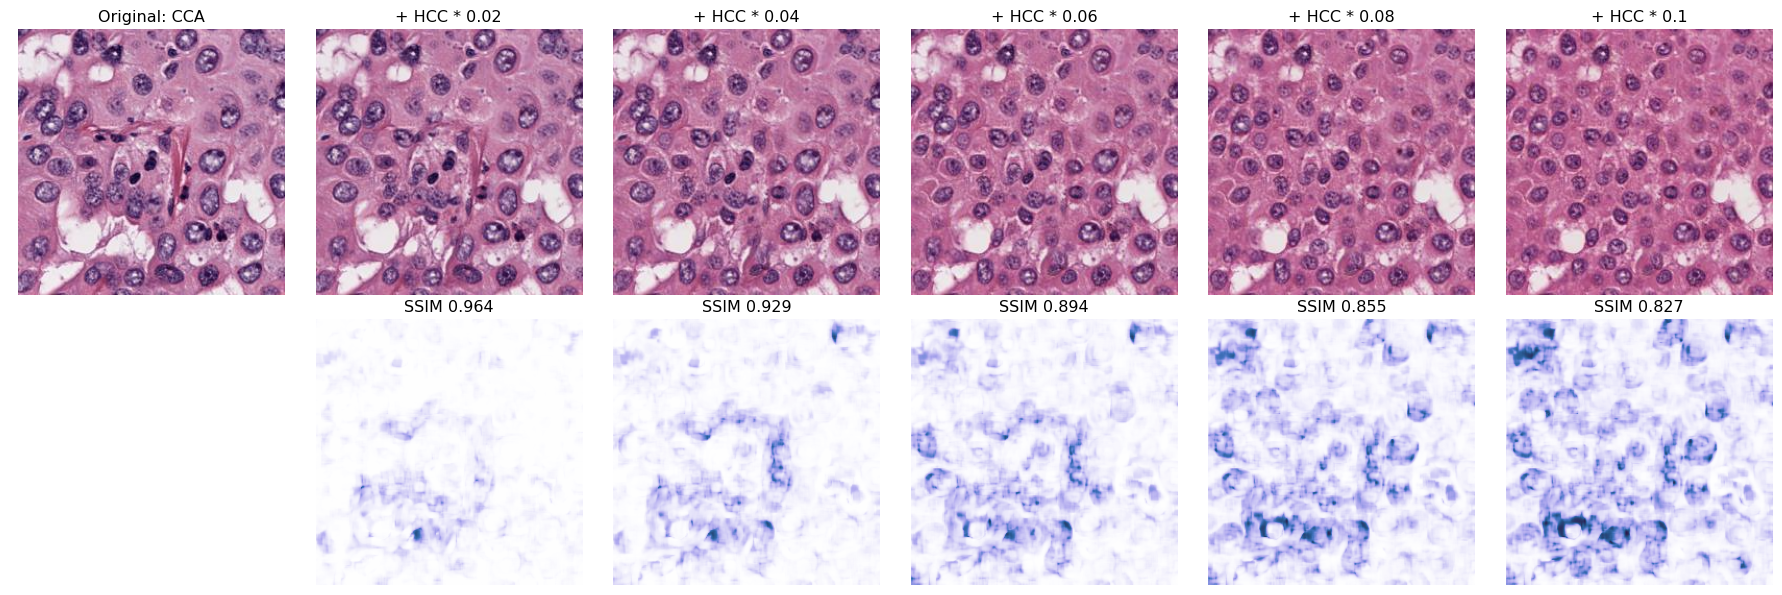

In [10]:
num_rows=2
num_cols=6

# scale all difference images for direct comparison
global_min = min([diff.min() for diff, _,_,_ in sim])
global_max = max([diff.max() for diff,_,_,_ in sim])

img_height, img_width = (300, 300)
dpi = 96 # Display resolution (dots per inch)
fig_width = (img_width * num_cols) / dpi
fig_height = (img_height * num_rows) / dpi

gt_class = 'CCA'
target_class = 'HCC'

fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi)

ax[0,0].imshow(ori)
ax[0,0].axis('off')
ax[0,0].set_title(f'Original: {gt_class}')
ax[1,0].axis('off')

for i in range(len(res)):
    manip_img = res[i]
    ax[0,i+1].imshow(manip_img)
    ax[0,i+1].set_title(f"+ {target_class} * {str(lvls[i])}")
    ax[0,i+1].axis('off')

    img = ax[1,i+1].imshow(sim[i][0], cmap=cm.devon, vmin=global_min, vmax=global_max)
    ax[1,i+1].set_title("SSIM {sim:.3f}".format(sim = sim[i][1]))
    ax[1,i+1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(f"images/example_liver_cancer_types_mil/{image_name}", f"{image_name}_all_ssim.png"), bbox_inches='tight')